We build a 5-layer convolutional neural network that progressively reduces the spatial dimension of the feature map, followed by global pooling and class projection layer.

We train and evaluate the network using the MNIST dataset.

In [1]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import autodiff as ad
from autodiff import initializers
from autodiff import optimizers

random_state = np.random.RandomState(0)

In [2]:
def read_mnist_labels(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    labels = np.zeros((num_images, 10), dtype=np.float32)
    indices = np.fromstring(content[8:], dtype=np.uint8)
    labels[range(num_images), indices] += 1
    
  return labels  

In [3]:
def read_mnist_images(fn):
  with gzip.open(fn, 'rb') as f:
    content = f.read()
    num_images = int.from_bytes(content[4:8], byteorder='big')
    height = int.from_bytes(content[8:12], byteorder='big')
    width = int.from_bytes(content[12:16], byteorder='big')
    images = np.fromstring(content[16:], dtype=np.uint8).reshape((num_images, height, width))
  images = images.astype(np.float32) / 255.  
  return images  

Make sure you have the downloaded the following 4 files, and place them under the current directory.

In [4]:
train_images = read_mnist_images('train-images-idx3-ubyte.gz')
train_labels = read_mnist_labels('train-labels-idx1-ubyte.gz')
test_images = read_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = read_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [5]:
tni = initializers.TruncatedNormalInitializer(mean=0.0, stddev=0.01, seed=0)
zi = initializers.ZerosInitializer()
oi = initializers.OnesInitializer()

The convolutional neural network has 5 3x3 convolutional layers that make the output stride 8 (`2^3`) before the global pooling. Each conv layer is batch-normalized:

|layers|kernel|stride|depth|sptatial dimension|
|-|-|-|-|-|
|Conv1_1|3|1|16|28|
|Conv1_2|3|2|32|14|
|Conv2_1|3|1|64|14|
|Conv2_2|3|2|128|7|
|Conv3|3|2|256|4|
|global_pool|n/a|n/a|256|1|
|dense|n/a|n/a|10|1|

In [6]:
def build_conv_net(is_training=True, epsilon=1e-3, decay=0.997):
  inputs = ad.placeholder((None, 28, 28, 1))
  labels = ad.placeholder((None, 10))

  weight_conv1_1 = ad.variable((3, 3, 1, 16), tni)
  scale_conv1_1 = ad.variable((16,), oi)
  offset_conv1_1 = ad.variable((16,), zi)
  moving_mean_conv1_1 = ad.variable((16,), zi, trainable=False)
  moving_variance_conv1_1 = ad.variable((16,), oi, trainable=False)

  weight_conv1_2 = ad.variable((3, 3, 16, 32), tni)
  scale_conv1_2 = ad.variable((32,), oi)
  offset_conv1_2 = ad.variable((32,), zi)
  moving_mean_conv1_2 = ad.variable((32,), zi, trainable=False)
  moving_variance_conv1_2 = ad.variable((32,), oi, trainable=False)

  weight_conv2_1 = ad.variable((3, 3, 32, 64), tni)
  scale_conv2_1 = ad.variable((64,), oi)
  offset_conv2_1 = ad.variable((64,), zi)
  moving_mean_conv2_1 = ad.variable((64,), zi, trainable=False)
  moving_variance_conv2_1 = ad.variable((64,), oi, trainable=False)

  weight_conv2_2 = ad.variable((3, 3, 64, 128), tni)
  scale_conv2_2 = ad.variable((128,), oi)
  offset_conv2_2 = ad.variable((128,), zi)
  moving_mean_conv2_2 = ad.variable((128,), zi, trainable=False)
  moving_variance_conv2_2 = ad.variable((128,), oi, trainable=False)

  weight_conv3 = ad.variable((3, 3, 128, 256), tni)
  scale_conv3 = ad.variable((256,), oi)
  offset_conv3 = ad.variable((256,), zi)
  moving_mean_conv3 = ad.variable((256,), zi, trainable=False)
  moving_variance_conv3 = ad.variable((256,), oi, trainable=False)

  weight_fc = ad.variable((256, 10), tni)
  bias_fc = ad.variable((10,), zi)

  
  conv1_1 = ad.relu(ad.fused_batch_norm(ad.conv2d(inputs, weight_conv1_1, [1, 1], 'SAME'), 
                                        scale_conv1_1, offset_conv1_1, 
                                        moving_mean_conv1_1, moving_variance_conv1_1, 
                                        epsilon=epsilon, decay=decay, is_training=is_training))
  conv1_2 = ad.relu(ad.fused_batch_norm(ad.conv2d(conv1_1, weight_conv1_2, [2, 2], 'SAME'), 
                                        scale_conv1_2, offset_conv1_2, 
                                        moving_mean_conv1_2, moving_variance_conv1_2, 
                                        epsilon=epsilon, decay=decay, is_training=is_training))

  conv2_1 = ad.relu(ad.fused_batch_norm(ad.conv2d(conv1_2, weight_conv2_1, [1, 1], 'SAME'), 
                                        scale_conv2_1, offset_conv2_1, 
                                        moving_mean_conv2_1, moving_variance_conv2_1, 
                                        epsilon=epsilon, decay=decay, is_training=is_training))
  conv2_2 = ad.relu(ad.fused_batch_norm(ad.conv2d(conv2_1, weight_conv2_2, [2, 2], 'SAME'), 
                                        scale_conv2_2, offset_conv2_2, 
                                        moving_mean_conv2_2, moving_variance_conv2_2, 
                                        epsilon=epsilon, decay=decay, is_training=is_training))

  conv3 = ad.relu(ad.fused_batch_norm(ad.conv2d(conv2_2, weight_conv3, [2, 2], 'SAME'), 
                                      scale_conv3, offset_conv3, 
                                      moving_mean_conv3, moving_variance_conv3, 
                                      epsilon=epsilon, decay=decay, is_training=is_training))

  pool = ad.reduce_mean(conv3, [1, 2])
  logits = ad.matmul(pool, weight_fc) + bias_fc

  losses = ad.softmax_cross_entropy_loss(labels=labels, logits=logits)
  loss = ad.reduce_mean(losses)
  return logits, loss, inputs, labels, pool

We create two separate graphs, which hold the network with BN in training mode and test mode, respectively.

Note here the decay is set to 0.9 (as opposed to values closer to 1.), because we will train for a relatively small number of steps i.e. 1000. This would allow the moving average of mean and variance for batch normalization to forget the old values more quickly (i.e. old values decay faster). 

NOTE: we let the function `build_conv_net` output the reference to the node `pool`.
We will later use that to visualize vector representation of digits.

In [7]:
train_graph = ad.Graph()
with train_graph.as_default_graph():
  (logits_train, loss, inputs_train, labels_train, _
    ) = build_conv_net(is_training=True, decay=0.9)


test_graph = ad.Graph()
with test_graph.as_default_graph():
  (logits_test, _, inputs_test, _, pool
    ) = build_conv_net(is_training=False, decay=0.9)

Create two RunTime instances, so the two graphs can be run separately.

In [8]:
train_graph.initialize_variables()
train_runtime = ad.RunTime()
train_graph.set_runtime(train_runtime)

test_graph.initialize_variables()
test_runtime = ad.RunTime()
test_graph.set_runtime(test_runtime)

# Get references to variables in train graph and test graph.
# So we can later copy weights of variables from train graph to test graph.
train_vars = train_graph.get_variables(False)
test_vars = test_graph.get_variables(False)

We use the more sophisticated optimizer Adam to optimize the 5-layer CNN.

In [9]:
adam = optimizers.AdamOptimizer(alpha=0.001, beta1=.9, beta2=.999, epsilon=1e-8)

We print the loss and accuracy on the training mini batch every 50 steps.

In [10]:
batch = 50
iterations = 1000

for i in range(iterations):
  which = random_state.choice(train_images.shape[0], batch, False)
  inputs_val = train_images[which].reshape((-1, 28, 28, 1))
  labels_val = train_labels[which]

  feed_dict = {inputs_train: inputs_val, labels_train: labels_val}

  with train_runtime.forward_backward_cycle():
    adam.optimize(loss, feed_dict)
    if i % 50 == 0:
      loss_val = loss.forward(feed_dict)
      logits_train_val = logits_train.forward(feed_dict)
      print('step: %d, loss: %f, accuracy: %f' % (i, 
          loss_val, np.mean(np.argmax(logits_train_val, axis=1) == np.argmax(labels_val, axis=1))))

step: 0, loss: 2.301459, accuracy: 0.080000
step: 50, loss: 0.761592, accuracy: 0.800000
step: 100, loss: 0.141254, accuracy: 1.000000
step: 150, loss: 0.246652, accuracy: 0.940000
step: 200, loss: 0.203953, accuracy: 0.960000
step: 250, loss: 0.135640, accuracy: 0.980000
step: 300, loss: 0.092858, accuracy: 0.980000
step: 350, loss: 0.101023, accuracy: 0.960000
step: 400, loss: 0.064740, accuracy: 1.000000
step: 450, loss: 0.020589, accuracy: 1.000000
step: 500, loss: 0.142395, accuracy: 0.960000
step: 550, loss: 0.098777, accuracy: 0.960000
step: 600, loss: 0.077568, accuracy: 0.960000
step: 650, loss: 0.012485, accuracy: 1.000000
step: 700, loss: 0.069185, accuracy: 0.960000
step: 750, loss: 0.040801, accuracy: 1.000000
step: 800, loss: 0.043003, accuracy: 0.980000
step: 850, loss: 0.115365, accuracy: 0.980000
step: 900, loss: 0.033787, accuracy: 1.000000
step: 950, loss: 0.029419, accuracy: 1.000000


We evaluate the trained network on the test set by running the test graph.

In [11]:
# Copy weights of variables in the train graph to corresponding variables in test graph
for test_var, train_var in zip(test_vars, train_vars):
  test_var.set_val(train_var.val)

feed_dict = {inputs_test: test_images.reshape((-1, 28, 28, 1))}
labels_val = test_labels
  
with test_runtime.forward_backward_cycle():
  logits_test_val = logits_test.forward(feed_dict)
      
print('test accuracy', np.mean(np.argmax(logits_test_val, axis=1) == np.argmax(labels_val, axis=1)))

test accuracy 0.9848


##### Visualize vector representation of digits

Recall that `pool` is the result of global pooling after the last conv layer (`conv3`), where each digit is represented by a vector of 256 dimensions. 

We will use t-SNE to get the embeddings in 2 dimensions for easy visualization.

In [12]:
with test_runtime.forward_backward_cycle():
  pool_val = pool.forward(feed_dict)

We have 10000 256-dimensional vectors for each digit in the test set, and we know their labels.

In [13]:
y_true = test_labels.argmax(axis=1)
  
print(pool_val.shape, y_true.shape)

(10000, 256) (10000,)


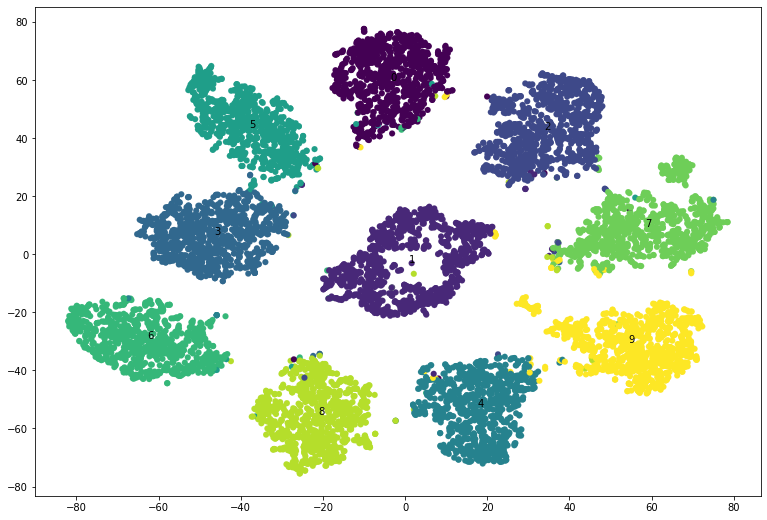

In [14]:
tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(pool_val)

plt.scatter(x=embedding_2d[:, 0], y=embedding_2d[:, 1], c=y_true, linewidths=0.1)    

fig = plt.gcf()
fig.set_size_inches(13, 9)

for i in range(10):
    x, y = embedding_2d[y_true == i, :].mean(axis=0)
    plt.text(x, y, str(i))

We can see that the 2-D representation of digits form 10 blobs that are easily separated from each other. And they turn out to correspond to each of the 10 digits.